References :    
    [rxrx.ai](http://rxrx.ai)    
    https://www.kaggle.com/jesucristo/quick-visualization-eda    

# <span style="font-family:Papyrus; font-size:2em;">Recursion Cellular Image Classification</span>
# <span style="font-family:Papyrus; font-size:1em;">CellSignal: Disentangling biological signal from experimental noise in cellular images</span>

![](https://assets.website-files.com/5cb63fe47eb5472014c3dae6/5d040176f0a2fd66df939c51_figure1%400.75x.png)

# <span style="font-family:Papyrus; font-size:1em;">Experiment Structure</span>

![](https://assets.website-files.com/5cb63fe47eb5472014c3dae6/5d03fe719710ab238b5b41b3_384%20Well%402x.png)




# <span style="font-family:Papyrus; font-size:1em;">Images of two different genetic conditions (rows) in HUVEC cells across four experimental batches (columns)</span>

![](https://assets.website-files.com/5cb63fe47eb5472014c3dae6/5d040176beb559547adf9464_figure1.png)

# <span style="font-family:Papyrus; font-size:1em;">Each well site has 6-channel fluorescent microscopy images</span>

![](https://www.kaggleusercontent.com/kf/16548690/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..UnqOr4CpUjW-5miqdOOSVw.gLsqtIjKR6KozOuYs83v1M_6M5mb1gqwC03CSn9-OAfOEXV6ernPyuMqXpnM6r-M_0iIfIqFU4PWG-Lze_0vfHAMuuQL-MuHdd3ULQNL0Cx7pHR-inpJOaK2XPQ1tJm7VYQhfW4YVdEZrua9S4YLLA.NRRRexPYHU8k3wmAsr1MVQ/__results___files/__results___10_0.png)

![](https://www.researchgate.net/profile/Anne_Carpenter/publication/281820875/figure/fig1/AS:324710484201472@1454428420318/Cell-Painting-assay-U2OS-cells-prepared-for-this-study-were-stained-using-the-Cell.png)

## Let us begin!!

In [1]:
import os, sys
import random
import numpy as np 
import pandas as pd

from PIL import Image
from PIL import Image

from datetime import datetime
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

import torchvision
from torchvision import transforms as T

import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
path_data="/data/kaggle/recursion-cellular-image-classification"

## View the file structure

In [3]:
! ls -lahtr $path_data

total 16G
----------  1 root root 1.2M Jun 26 13:01 train.csv
----------  1 root root  57M Jun 26 13:01 pixel_stats.csv
-rw-r--r--  1 root root  18M Sep 29 05:22 pixel_stats.csv.zip
-rw-r--r--  1 root root 359K Sep 29 05:22 sample_submission.csv
-rw-r--r--  1 root root 562K Sep 29 05:22 test.csv
-rw-r--r--  1 root root 112K Sep 29 05:22 test_controls.csv
-rw-r--r--  1 root root 236K Sep 29 05:22 train.csv.zip
-rw-r--r--  1 root root 204K Sep 29 05:22 train_controls.csv
-rw-r--r--  1 root root  35K Sep 29 05:22 recursion_dataset_license.pdf
-rw-r--r--  1 root root  16G Sep 29 05:25 test.zip
drwxr-xr-x  3 root root 4.0K Sep 29 05:32 ..
drwxrwxrwx  3 root root 4.0K Sep 29 05:36 .
drwxr-xr-x 35 root root 4.0K Sep 29 05:36 train


## Load our files

In [4]:
batch_size = 64

In [5]:
# path_data = '../input/recursion-cellular-image-classification/'
trnalldf = pd.read_csv(os.path.join(path_data, 'train.csv'))
tstdf = pd.read_csv(os.path.join(path_data, 'test.csv'))
statsdf = pd.read_csv(os.path.join(path_data, 'pixel_stats.csv'))

## Now lets view the file contents

In [6]:
trnalldf.iloc[0]

id_code       HEPG2-01_1_B03
experiment          HEPG2-01
plate                      1
well                     B03
sirna                    513
Name: 0, dtype: object

In [7]:
# lets look at the samples per per experiments
tstdf.experiment.value_counts().sort_index()

HEPG2-08    1107
HEPG2-09    1108
HEPG2-10    1108
HEPG2-11    1106
HUVEC-17    1108
HUVEC-18    1107
HUVEC-19    1108
HUVEC-20    1108
HUVEC-21    1108
HUVEC-22    1108
HUVEC-23    1099
HUVEC-24    1100
RPE-08      1108
RPE-09      1107
RPE-10      1108
RPE-11      1094
U2OS-04     1108
U2OS-05     1097
Name: experiment, dtype: int64

In [8]:
# Lets take the first 3 experiments as train, and the next 4 as val
valdf = trnalldf[trnalldf.experiment.str.contains('01')]
trndf = trnalldf[trnalldf.experiment.str.contains('02|03|04|05|06|07')]

In [9]:
print('Train frame shape : rows {} cols {}'.format(*trndf.shape))
print('Val frame shape : rows {} cols {}'.format(*valdf.shape))
print('Test frame shape : rows {} cols {}'.format(*tstdf.shape))

Train frame shape : rows 22151 cols 5
Val frame shape : rows 4430 cols 5
Test frame shape : rows 19897 cols 4


## Let's look at experiment batch impact

In [10]:
statsdf.iloc[0]

id_code       HEPG2-01_1_B02
experiment          HEPG2-01
plate                      1
well                     B02
site                       1
channel                    1
mean                 71.0638
std                  43.1462
median                    67
min                        7
max                      255
Name: 0, dtype: object

In [11]:
meanexpdf = statsdf.groupby(['experiment', 'channel'])['mean'].mean().unstack()
stdexpdf = statsdf.groupby(['experiment', 'channel'])['mean'].mean().unstack()
meanexpdf[meanexpdf.index.str.contains('01|02')]

channel,1,2,3,4,5,6
experiment,,,,,,
HEPG2-01,37.947925,26.399949,34.723836,40.014089,43.965592,30.804353
HEPG2-02,33.405073,27.128854,29.582297,46.010937,32.501942,31.144117
HUVEC-01,4.123238,19.956227,10.233502,10.657920,2.326737,12.136189
HUVEC-02,4.448384,20.802760,8.897859,10.869585,2.442969,11.343739
RPE-01,3.618764,10.956121,16.646254,7.829697,3.690766,13.503024
RPE-02,2.978969,8.812340,14.565686,6.347397,3.799188,12.526606
U2OS-01,7.537577,10.093597,10.044440,7.385857,3.014662,13.574783
U2OS-02,11.160868,12.521636,12.274936,10.068334,3.290966,16.674154


In [12]:
# We can see large differences by  
meanexpdf.loc['HEPG2-01'].values

array([37.94792521, 26.39994873, 34.72383564, 40.0140892 , 43.96559181,
       30.80435258])

## We will bring in some augmentations from Albumentations - check it out

# <span style="font-family:Papyrus; font-size:1em;">Albumentations</span>

![](https://camo.githubusercontent.com/041633dc5d522d6cf583a81d4a1d85be87f44155/68747470733a2f2f686162726173746f726167652e6f72672f776562742f652d2f366b2f7a2d2f652d366b7a2d66756770326865616b336a7a6e733362632d72386f2e6a706567)

In [13]:
from albumentations import (Cutout, Compose, Normalize, RandomRotate90, HorizontalFlip,
                           VerticalFlip, ShiftScaleRotate, Transpose, OneOf, IAAAdditiveGaussianNoise,
                           GaussNoise, RandomGamma, RandomContrast, RandomBrightness, HueSaturationValue,
                           RandomCrop, Lambda, NoOp, CenterCrop, Resize)

In [14]:
def aug(p=1.):
    return Compose([
        RandomRotate90(),
        HorizontalFlip(),
        VerticalFlip(),
        Transpose(),
        NoOp(),
    ], p=p)

## Data loader - we make a class and use torch loader

In [15]:
class ImagesDS(D.Dataset):
    def __init__(self, df, img_dir, size = 256, mode='train', meandf = meanexpdf, stddf = stdexpdf, channels=[1,2,3,4,5,6]):
        
        self.records = df.to_records(index=False)
        self.channels = channels
        self.site = random.randint(1,2) # load a random site from each well.
        self.mode = mode
        self.meandf = meanexpdf
        self.stddf = stdexpdf
        self.img_dir = img_dir
        self.len = df.shape[0]
        self.size = size
        self.augtransform = aug()
        
    @staticmethod
    def _load_img_as_tensor(file_name, size):
        with Image.open(file_name) as img:
            img = img.resize((size, size), resample=Image.BICUBIC)
            return img
        
    @staticmethod
    def torch_augment(img, transform, mean_, sd_):
        img = img.astype(np.float32)
        img = transform(image = img)['image']
        img = torch.from_numpy(np.moveaxis(img, -1, 0).astype(np.float32))
        img = T.Normalize([*list(mean_)], [*list(sd_)])(img)
        return img  

    def _get_img_path(self, index, channel):
        experiment, well, plate = self.records[index].experiment, self.records[index].well, self.records[index].plate
        return '/'.join([self.img_dir,self.mode,experiment,f'Plate{plate}',f'{well}_s{self.site}_w{channel}.png'])
        
    def __getitem__(self, index):
        paths = [self._get_img_path(index, ch) for ch in self.channels]
        
        # Normalise values
        meanvals = self.meandf.loc[self.records[index].experiment].values
        stdvals = self.stddf.loc[self.records[index].experiment].values
        
        # Load image
        img = np.stack([self._load_img_as_tensor(img_path, self.size) for (img_path, m, s) in zip(paths, meanvals, stdvals)], -1)
        img = self.torch_augment(img, self.augtransform, meanvals, stdvals)      
        
        if self.mode == 'train':
            return img, self.records[index].sirna
        else:
            return img, self.records[index].id_code

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [16]:
trnloader = D.DataLoader(ImagesDS(trndf, path_data, mode='train'), batch_size=batch_size, shuffle=True, num_workers=8)
valloader = D.DataLoader(ImagesDS(valdf, path_data, mode='train'), batch_size=batch_size*4, shuffle=False, num_workers=8)
tstloader = D.DataLoader(ImagesDS(tstdf, path_data, mode='test'), batch_size=batch_size*4, shuffle=False, num_workers=8)

In [17]:
X,y = next(iter(trnloader))

In [18]:
X.mean(), X.std()

(tensor(0.0181), tensor(1.0445))

In [19]:
print('Batch Shape : {}'.format(X.shape))
print('Label Shape : {}'.format(y.shape))

Batch Shape : torch.Size([64, 6, 256, 256])
Label Shape : torch.Size([64])


## Let's set up our model...



# <span style="font-family:Papyrus; font-size:1em;">Densenet121</span>

![](https://d3i71xaburhd42.cloudfront.net/501d99e392783e4acafb220136d32ea68a921282/1-Figure1-1.png)

In [20]:
class DenseNet(nn.Module):
    def __init__(self, num_classes=1000, num_channels=6):
        super().__init__()
        preloaded = torchvision.models.densenet121(pretrained=True)
        self.features = preloaded.features
        self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)
        self.classifier = nn.Linear(1024, num_classes, bias=True)
        del preloaded
        
    def forward(self, x, emb=False):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        if emb:
            return out
        out = self.classifier(out)
        return out

In [21]:
model = DenseNet(num_classes=trndf.sirna.max()+1, num_channels = 6)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 39.4MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inp

In [22]:
dir(model)[-10:]

['register_forward_pre_hook',
 'register_parameter',
 'requires_grad_',
 'share_memory',
 'state_dict',
 'to',
 'train',
 'training',
 'type',
 'zero_grad']

In [23]:
# Look at the first 10 layers
[(n, w.shape) for t, (n,w) in enumerate(model.named_parameters()) if t <10]

[('features.conv0.weight', torch.Size([64, 6, 7, 7])),
 ('features.conv0.bias', torch.Size([64])),
 ('features.norm0.weight', torch.Size([64])),
 ('features.norm0.bias', torch.Size([64])),
 ('features.denseblock1.denselayer1.norm1.weight', torch.Size([64])),
 ('features.denseblock1.denselayer1.norm1.bias', torch.Size([64])),
 ('features.denseblock1.denselayer1.conv1.weight',
  torch.Size([128, 64, 1, 1])),
 ('features.denseblock1.denselayer1.norm2.weight', torch.Size([128])),
 ('features.denseblock1.denselayer1.norm2.bias', torch.Size([128])),
 ('features.denseblock1.denselayer1.conv2.weight',
  torch.Size([32, 128, 3, 3]))]

### Lets look at a single layer

In [35]:
model.features.denseblock2.denselayer10.conv2.weight[:1]

tensor([[[[-0.0104, -0.0378, -0.0206],
          [-0.0457,  0.0066, -0.0260],
          [-0.0073, -0.0181,  0.0089]],

         [[-0.0338, -0.0192, -0.0333],
          [-0.0413, -0.0283, -0.0355],
          [-0.0078,  0.0159,  0.0169]],

         [[-0.0581, -0.0621, -0.0648],
          [-0.0457, -0.0352, -0.0481],
          [-0.0410, -0.0334, -0.0686]],

         ...,

         [[-0.0399, -0.0263, -0.0461],
          [-0.0614, -0.0810, -0.0776],
          [-0.0065, -0.0465, -0.0232]],

         [[ 0.0409, -0.0264,  0.0072],
          [-0.0058, -0.0172, -0.0186],
          [-0.0031, -0.0018, -0.0408]],

         [[-0.0110, -0.0634, -0.0400],
          [ 0.0096, -0.0769, -0.0161],
          [-0.0323, -0.0333, -0.0519]]]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SliceBackward>)

## Mixed Precision Training
We saw apex in homework 6. This allows certain parts of the network to be stored in FP32 (32-bit floating point) and other parts to be stored in FP16
With a few small code changes we can half runtime... essential in the large networks outperforming today.

In [25]:
%%capture
# install NVIDIA Apex if needed to support mixed precision training
use_amp = True
if use_amp:
    try:
        from apex import amp
    except ImportError:
        !pip install  -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/*/*/NVIDIA-apex*
        from apex import amp

## Use one cycle to get optimum LR

In [26]:
device = 'cuda'
model = DenseNet(num_classes=trndf.sirna.max()+1, num_channels = 6)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", keep_batchnorm_fp32=False, loss_scale="dynamic")

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : True
loss_scale             : dynamic


## [One Cycle Policy](https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy)

In [27]:
# One cycle policy https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy
optimizer.param_groups[0]['lr'] = .001 
onecycdf = trnalldf
onecycleloader = D.DataLoader(ImagesDS(onecycdf, path_data, mode='train'), batch_size=batch_size, shuffle=True, num_workers=8)
print('Total Step Count : {}'.format(len(onecycleloader)))


Total Step Count : 571


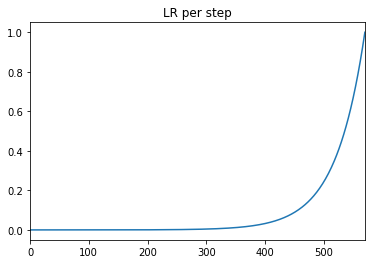

In [36]:
import math
init_value = 1e-5
final_value=1.
beta = 0.98
avg_loss = 0.
batch_num = 0
numsteps = len(onecycleloader)-1
mult = (final_value / init_value) ** (1/numsteps )
lrvals = pd.Series([init_value*(mult**i) for i in  range(numsteps+ 1)])
lrvals.plot(title='LR per step')

In [29]:
lossls = []
optimizer.param_groups[0]['lr'] = init_value
for t, (x, y) in enumerate(onecycleloader): 
    optimizer.zero_grad()
    x = x.to(device)#.half()
    y = y.cuda()
    x = torch.autograd.Variable(x, requires_grad=True)#.half()
    y = torch.autograd.Variable(y)
    out = model(x)
    loss = criterion(out, y)
    with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()
    optimizer.step()
    optimizer.param_groups[0]['lr'] = init_value*(mult**t)
    
    ######One Cycle Policy##########>
    #Compute the smoothed loss
    batch_num += 1
    avg_loss = beta * avg_loss + (1-beta) *loss.item()
    smoothed_loss = avg_loss / (1 - beta**batch_num)
    lossls.append(smoothed_loss)

    if t%20==0:
        print('Step {} lr {:.6f} smoothed loss {:.5f} time {}'.format(t, init_value*(mult**t), smoothed_loss, datetime.now()))
    del loss, out, y, x# , target

Step 0 lr 0.000010 smoothed loss 7.08925 time 2019-09-29 05:57:42.620021
Step 20 lr 0.000015 smoothed loss 7.10953 time 2019-09-29 05:58:14.849014
Step 40 lr 0.000022 smoothed loss 7.11701 time 2019-09-29 05:59:14.612286
Step 60 lr 0.000034 smoothed loss 7.11733 time 2019-09-29 06:00:32.777428
Step 80 lr 0.000050 smoothed loss 7.10666 time 2019-09-29 06:01:41.171489
Step 100 lr 0.000075 smoothed loss 7.09828 time 2019-09-29 06:02:53.601736
Step 120 lr 0.000113 smoothed loss 7.08193 time 2019-09-29 06:04:00.146326
Step 140 lr 0.000169 smoothed loss 7.07581 time 2019-09-29 06:05:13.710083
Step 160 lr 0.000253 smoothed loss 7.06566 time 2019-09-29 06:06:23.528268
Step 180 lr 0.000379 smoothed loss 7.06292 time 2019-09-29 06:07:28.463159
Step 200 lr 0.000568 smoothed loss 7.05510 time 2019-09-29 06:08:43.422192
Step 220 lr 0.000851 smoothed loss 7.06461 time 2019-09-29 06:09:55.667572
Step 240 lr 0.001274 smoothed loss 7.06003 time 2019-09-29 06:11:12.668408
Gradient overflow.  Skipping st

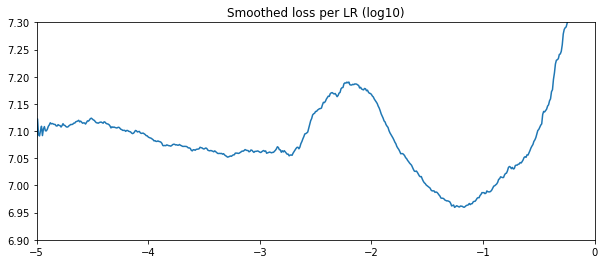

In [30]:
pd.Series(lossls, index=np.log10(lrvals)).plot(title='Smoothed loss per LR (log10)', ylim=(6.9,7.3), figsize = (10,4))

## Create a Learning Rate Scheduler

In [82]:
%%capture
!pip install https://github.com/ceshine/pytorch_helper_bot/archive/0.0.5.zip
from helperbot import GradualWarmupScheduler
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [83]:
EPOCHS=40
lrmult=10
warmup_epochs=3
lr = 8e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=lrmult, \
                                          total_epoch=warmup_epochs, \
                                          after_scheduler=scheduler_cosine)

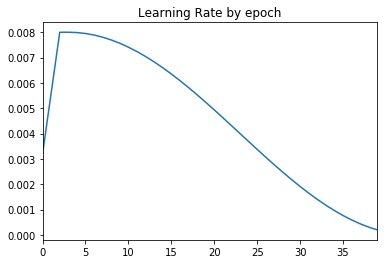

In [84]:
lrls = []
for e in range(EPOCHS):
    scheduler_warmup.step()
    lrls.append(scheduler_warmup.get_lr()[0])
pd.Series(lrls).plot(title='Learning Rate by epoch')

## Now we train up the model

In [89]:
model = DenseNet(num_classes=trndf.sirna.max()+1, num_channels = 6)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", keep_batchnorm_fp32=False, loss_scale="dynamic")
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=lrmult, \
                                          total_epoch=warmup_epochs, \
                                          after_scheduler=scheduler_cosine)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : True
loss_scale             : dynamic


In [137]:
@torch.no_grad()
def prediction(model, loader, emb=False):
    probs = []
    for x, _ in loader:
        x = x.to(device)
        output = model(x, emb)
        if not emb:
            output = torch.sigmoid(output.cpu()).numpy()
        else:
            output = output.cpu().numpy()
        probs.append(output)
    probs = np.concatenate(probs, 0)
    return probs

In [91]:
for epoch in range(EPOCHS):
    tloss = 0.
    model.train()
    scheduler_warmup.step()
    for t, (x, y) in enumerate(trnloader): 
        optimizer.zero_grad()
        x = x.to(device)
        y = y.cuda()
        x = torch.autograd.Variable(x, requires_grad=True)#.half()
        y = torch.autograd.Variable(y)
        out = model(x)
        loss = criterion(out, y)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
        tloss += loss.item() 
        del loss, out, y, x
    lrlog = scheduler_warmup.get_lr()[0]    
    model.eval()
    preds = prediction(model, valloader)
    val_accuracy = (valdf.sirna.values == preds.argmax(1)).mean()
    print('Epoch {} -> Train Loss: {:.4f} -> Val Acc: {:.4f} -> Lr: {:.5f} -> Time {}'.format(epoch+1, \
                                                        tloss/len(trnloader), val_accuracy, lrlog, \
                                                        datetime.now()))


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Epoch 1 -> Train Loss: 7.4485 -> Val Acc: 0.0018 -> Lr: 0.00320 -> Time 2019-09-29 15:34:40.866843
Epoch 2 -> Train Loss: 6.8480 -> Val Acc: 0.0025 -> Lr: 0.00560 -> Time 2019-09-29 15:38:36.032302
Epoch 3 -> Train Loss: 6.7108 -> Val Acc: 0.0050 -> Lr: 0.00800 -> Time 2019-09-29 15:42:29.463284
Epoch 4 -> Train Loss: 6.5740 -> Val Acc: 0.0036 -> Lr: 0.00800 -> Time 2019-09-29 15:46:24.706512
Epoch 5 -> Train Loss: 6.4538 -> Val Acc: 0.0077 -> Lr: 0.00799 -> Time 2019-09-29 15:50:19.017840
Epoch 6 -> Train Loss: 6.3151

## Save model to disk

In [163]:
output_model_file = "recursion_model.bin"
torch.save(model.state_dict(), output_model_file)

## Now please implement test time augmentation to make predictions

In [ ]:
## Load up the model
# model.load_state_dict(torch.load(os.path.join(path_data, "recursion_model.bin")))
# model.to(device)
# for param in model.parameters():
#     param.requires_grad = False
# model.eval()
# ....